Imports

In [1]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [2]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [3]:
scrap_games(years)

Read data

In [3]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)

    # search for missing values
    missing_values = seasons_games[year].isnull().sum()
    print(missing_values)
    
    # invalid scores
    invalid_scores = seasons_games[year][(seasons_games[year]['home_team_score'] < 40) 
                                         | (seasons_games[year]['home_team_score'] > 200)
                                         | (seasons_games[year]['away_team_score'] < 40)
                                         | (seasons_games[year]['away_team_score'] > 200)
                                         ]
    print(invalid_scores)


start_time         0
away_team          0
away_team_score    0
home_team          0
home_team_score    0
dtype: int64
Empty DataFrame
Columns: [start_time, away_team, away_team_score, home_team, home_team_score]
Index: []
start_time         0
away_team          0
away_team_score    0
home_team          0
home_team_score    0
dtype: int64
Empty DataFrame
Columns: [start_time, away_team, away_team_score, home_team, home_team_score]
Index: []


Edit dataframe

In [4]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())

# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']

Show data (first 5 rows)

In [5]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

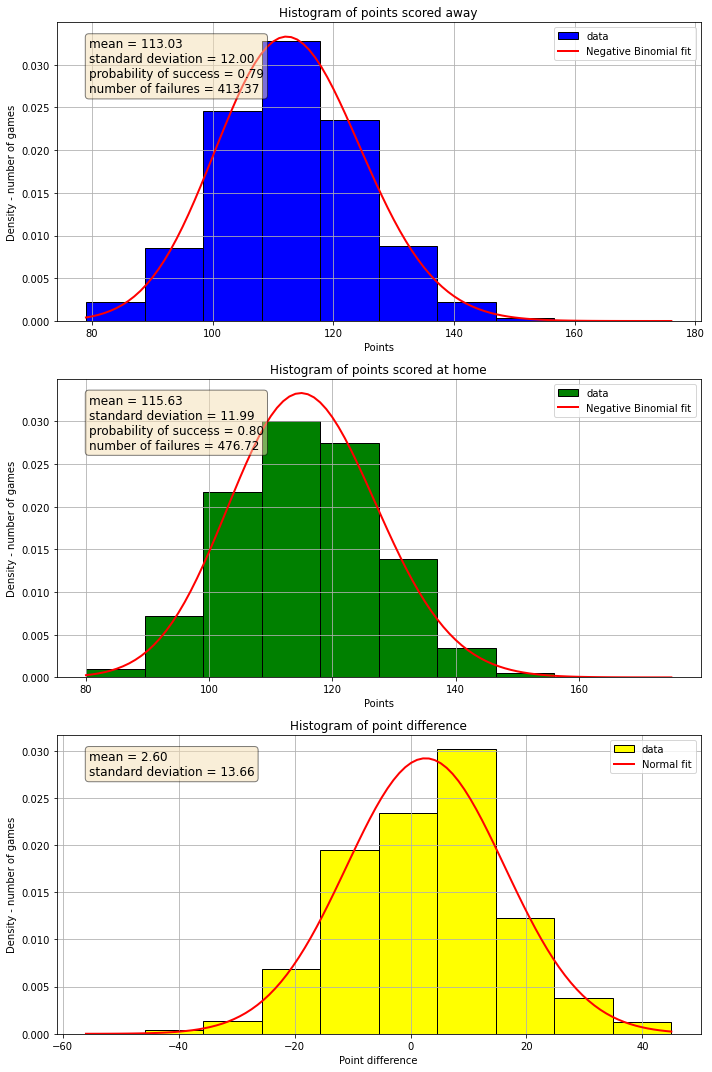

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    std = np.sqrt(var)
    if col == 'difference':
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}\nprobability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [7]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

In [8]:
for i in inp_data:
    print(inp_data[i])

30
1323
[ 1  2  3 ... 21 16 21]
[28 16 26 ... 16 21 16]
[127 114 123 ...  97 104  90]
[104 121 122 ... 107  94 103]


Modelling

Negative Binomial

Negative Binomial - prior

In [13]:
with open('src/model/model_4_prior.stan', 'r') as f:
    print(f.read())

generated quantities {
  int home_score_pred;
  int away_score_pred;

  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real sigma2_att;
  real sigma2_def;
  real phi_home;
  real phi_away;
  real c_offset;

  real log_mu_home;
  real log_mu_away;
  real home_att;
  real away_att;
  real home_def;
  real away_def;
  
  mu_home_att = normal_rng(0.2, 1);
  mu_away_att = normal_rng(0, 1);
  mu_home_def = normal_rng(-0.2, 1);
  mu_away_def = normal_rng(0, 1);
  sigma2_att = gamma_rng(10, 10);
  sigma2_def = gamma_rng(10, 10);
  phi_home = normal_rng(10, 10);
  phi_away = normal_rng(10, 10);
  // phi_home ~ gamma(2.5, 0.05);
  // phi_away ~ gamma(2.5, 0.05);
  // c_offset = normal_rng(1, 1);

  home_att = normal_rng(mu_home_att, sigma2_att);
  away_att = normal_rng(mu_away_att, sigma2_att);
  home_def = normal_rng(mu_home_def, sigma2_def);
  away_def = normal_rng(mu_away_def, sigma2_def);

  // log_mu_home = home_att + away_def + log(c_offset);
  // log_mu_aw

In [30]:
model_1_prior = CmdStanModel(stan_file='src/model/model_1_prior.stan')
samples = 1000
sim=model_1_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_1_prior.stan to exe file /app/src/model/model_1_prior


INFO:cmdstanpy:compiled model executable: /app/src/model/model_1_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [31]:
mod_1_post = sim.draws_pd()
print(mod_1_post)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0            122.0            108.0    -0.400201   
1      0.0            0.0            143.0            120.0     0.627040   
2      0.0            0.0             89.0            100.0    -0.235918   
3      0.0            0.0            100.0            110.0    -1.643750   
4      0.0            0.0             71.0            146.0    -0.247076   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0            120.0            121.0     1.166000   
3996   0.0            0.0            114.0            115.0    -0.540288   
3997   0.0            0.0            127.0            134.0     0.249941   
3998   0.0            0.0             76.0             62.0     0.380455   
3999   0.0            0.0            116.0             82.0    -1.453750   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

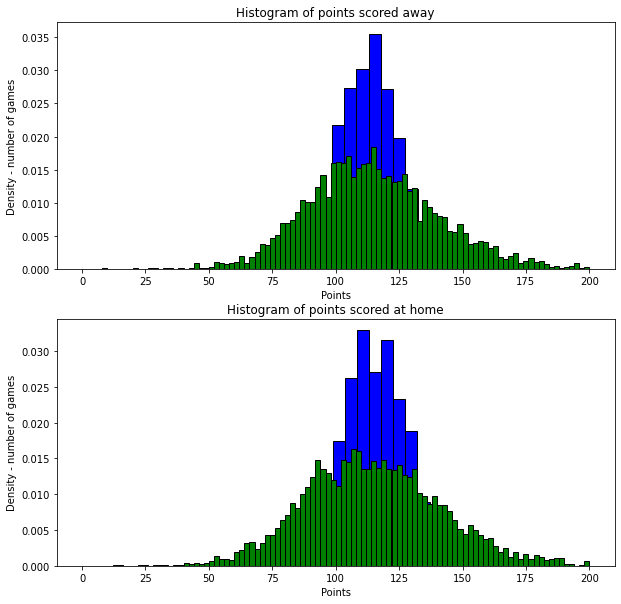

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')


/tmp/ipykernel_86202/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


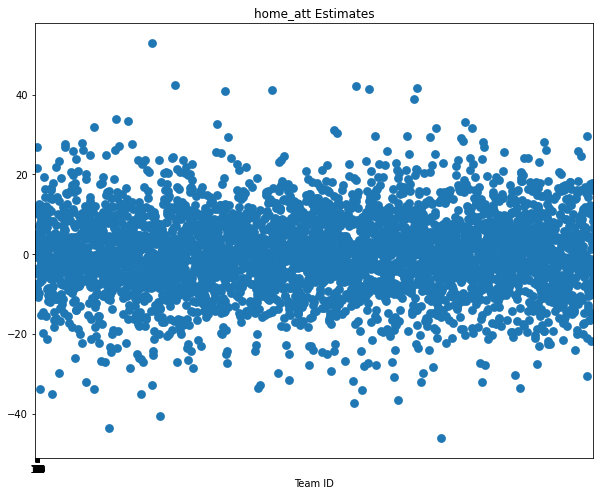

/tmp/ipykernel_86202/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


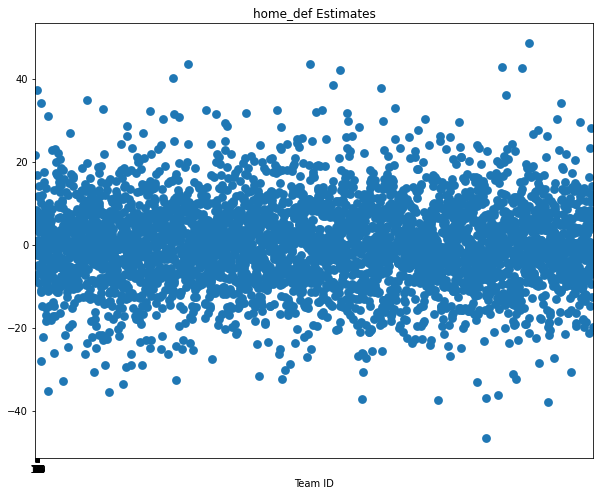

/tmp/ipykernel_86202/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


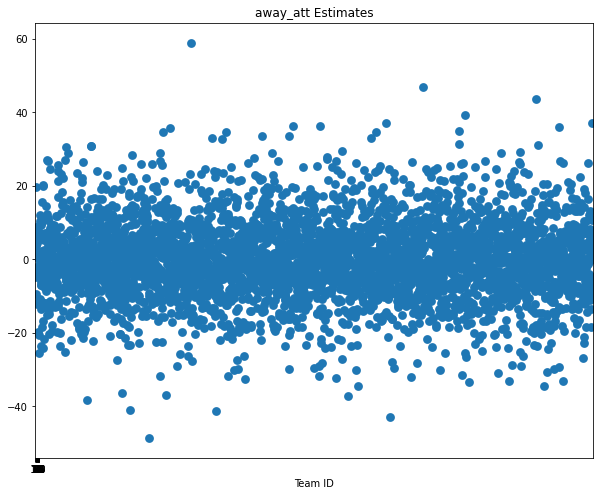

/tmp/ipykernel_86202/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


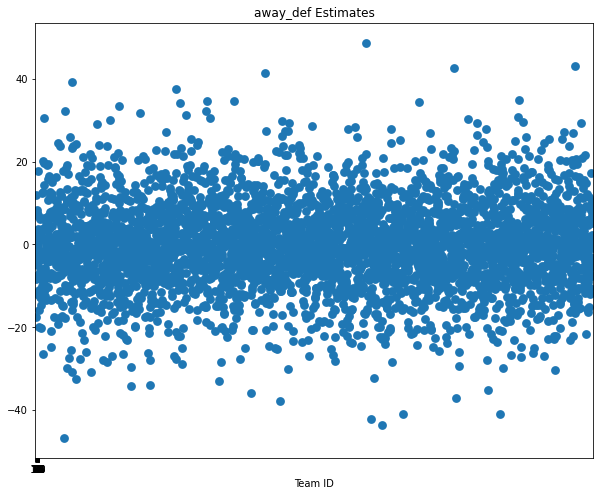

In [36]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
    
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

Model 1 - posterior

In [49]:
with open('src/model/model_1_posterior.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}

parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;
  real<lower=0> phi_home;
  real<lower=0> phi_away;
  real<lower=0> c_offset;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}

transformed parameters {
  vector[games_number] mu_home;
  vector[games_number] mu_away;
  // vector[teams_number] home_att;
  // vector[teams_number] away_att;
  // vector[teams_number] home_def;
  // vector[teams_number] away_def;

  // // need to make sum(att)=sum(def)=0
  // for (k in 1:(teams_number-1)) {
  //   home_att[k] = home_att_raw[k];
  //   away_att[k] = away_att_raw[k];
  //   

In [11]:
model_1_post = CmdStanModel(stan_file='src/model/model_4_posterior.stan')
samples = 1000
sim=model_1_post.sample(data=inp_data,
                        iter_sampling=samples,
                        # iter_warmup=1,
                        chains=4
                        )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing























chain 1 |████▌     | 00:55 Iteration:  800 / 2000 [ 40%]  (Warmup)
















chain 1 |█████     | 00:57 Iteration:  900 / 2000 [ 45%]  (Warmup)







chain 1 |█████▉    | 01:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)






chain 1 |██████▎   | 01:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 01:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)
















chain 1 |███████▎  | 01:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 01:13 Iteration: 1400 / 2000 [ 70%]  (Sampling)






chain 1 |████████▏ | 01:17 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 1 |█████████ | 01:24 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |█████████▌| 01:27 Iteration: 1800 / 2000 [ 90%]  (Sampling)




chain 1 |██████████| 01:30 Iteration: 1900 / 2000 [ 95%]  (Sampling)






































































INFO:cmdstanpy:CmdStan done processing.


In [12]:
mod_1_post = sim.draws_pd()
print(mod_1_post)

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0     1081190.0       0.957242    0.028738          7.0         127.0   
1     1081210.0       0.797098    0.028738          6.0          63.0   
2     1081190.0       0.781981    0.028738          6.0          63.0   
3     1081190.0       0.901744    0.028738          6.0          63.0   
4     1081190.0       0.808266    0.028738          6.0          63.0   
...         ...            ...         ...          ...           ...   
3995  1081430.0       0.878865    0.027723          7.0         127.0   
3996  1081420.0       0.665192    0.027723          7.0         127.0   
3997  1081430.0       0.706351    0.027723          7.0         127.0   
3998  1081410.0       0.750629    0.027723          7.0         127.0   
3999  1081430.0       0.792776    0.027723          7.0         127.0   

      divergent__   energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             0.0 -1081120.0     0.000041     0

In [28]:
print(sim.stan_variable('home_score_pred').flatten())

[ 97.  98. 112. ... 102.  87. 115.]


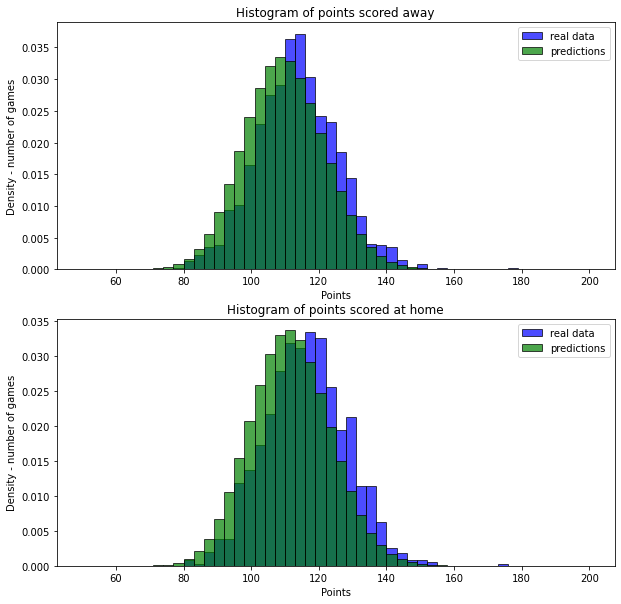

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=50, color='blue', edgecolor='black', alpha=0.7, label='real data', range=(50, 200))
axes[0].hist(sim.stan_variable('away_score_pred').flatten(), density=True, bins=50, color='green', edgecolor='black', alpha=0.7, label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')
axes[0].legend()

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=50, color='blue', edgecolor='black', alpha=0.7, label='real data', range=(50, 200))
axes[1].hist(sim.stan_variable('home_score_pred').flatten(), density=True, bins=50, color='green', edgecolor='black', alpha=0.7, label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
axes[1].legend()

In [ ]:
inp_data_2 = {
    'N_teams': len(teams),
    'N_games': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_list(),
    'away_team': seasons_games[train_year].away_team_id.to_list(),
    'home_points': seasons_games[train_year].home_team_score.to_list(),
    'away_points': seasons_games[train_year].away_team_score.to_list(),
    'home_field_advantage_threshold': 2
}

In [ ]:
model_2_post = CmdStanModel(stan_file='src/model/model_2_posterior.stan')
samples = 1000
sim=model_2_post.sample(data=inp_data_2,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_2_posterior.stan to exe file /app/src/model/model_2_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_2_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [36]:
mod_2_post = sim.draws_pd()
print(mod_2_post)

        lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0   -143.995            0.0     11.8029          0.0           1.0   
1   -143.995            0.0     11.8029          0.0           1.0   
2   -143.995            0.0     11.8029          0.0           1.0   
3   -143.995            0.0     11.8029          0.0           1.0   
4   -143.995            0.0     11.8029          0.0           1.0   
..       ...            ...         ...          ...           ...   
995 -143.995            0.0     11.8029          0.0           1.0   
996 -143.995            0.0     11.8029          0.0           1.0   
997 -143.995            0.0     11.8029          0.0           1.0   
998 -143.995            0.0     11.8029          0.0           1.0   
999 -143.995            0.0     11.8029          0.0           1.0   

     divergent__  energy__  theta_offense[1]  theta_offense[2]  \
0            1.0   183.948           2.84974           2.29701   
1            1.0   170.466 

In [39]:
for col in mod_2_post.columns:
    if col.startswith('theta_offense') or col.startswith('theta_defense') or col == 'home_field_advantage':
        print(col, mod_2_post[col])

theta_offense[1] 0      2.84974
1      2.84974
2      2.84974
3      2.84974
4      2.84974
        ...   
995    2.84974
996    2.84974
997    2.84974
998    2.84974
999    2.84974
Name: theta_offense[1], Length: 1000, dtype: float64
theta_offense[2] 0      2.29701
1      2.29701
2      2.29701
3      2.29701
4      2.29701
        ...   
995    2.29701
996    2.29701
997    2.29701
998    2.29701
999    2.29701
Name: theta_offense[2], Length: 1000, dtype: float64
theta_offense[3] 0     -1.24498
1     -1.24498
2     -1.24498
3     -1.24498
4     -1.24498
        ...   
995   -1.24498
996   -1.24498
997   -1.24498
998   -1.24498
999   -1.24498
Name: theta_offense[3], Length: 1000, dtype: float64
theta_offense[4] 0      4.13429
1      4.13429
2      4.13429
3      4.13429
4      4.13429
        ...   
995    4.13429
996    4.13429
997    4.13429
998    4.13429
999    4.13429
Name: theta_offense[4], Length: 1000, dtype: float64
theta_offense[5] 0      0.053535
1      0.053535
2      0.05

In [38]:
for col in mod_2_post.columns:
    if col == 'theta_offense_bar':
        print(col, mod_2_post[col])

theta_offense_bar 0     -0.528703
1     -0.528703
2     -0.528703
3     -0.528703
4     -0.528703
         ...   
995   -0.528703
996   -0.528703
997   -0.528703
998   -0.528703
999   -0.528703
Name: theta_offense_bar, Length: 1000, dtype: float64


/tmp/ipykernel_11258/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


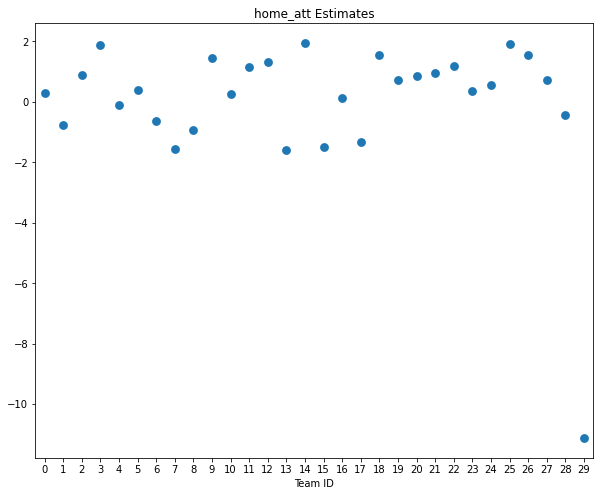

/tmp/ipykernel_11258/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


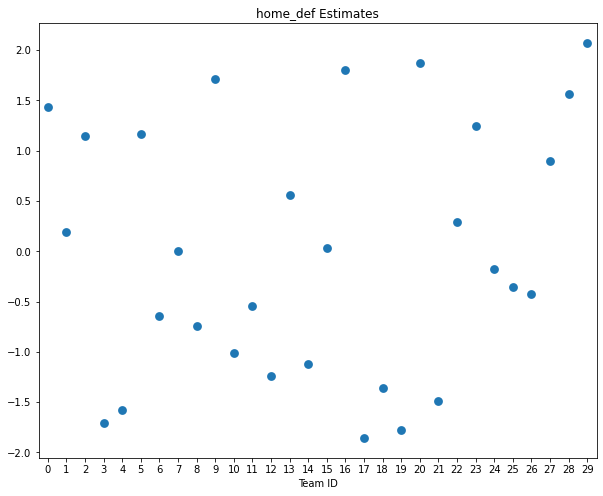

/tmp/ipykernel_11258/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


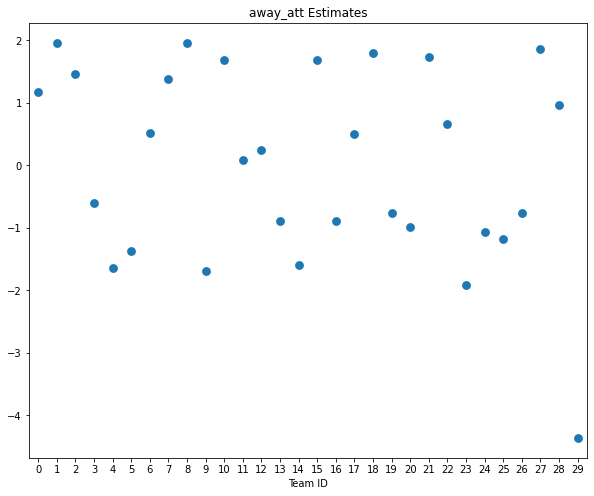

/tmp/ipykernel_11258/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


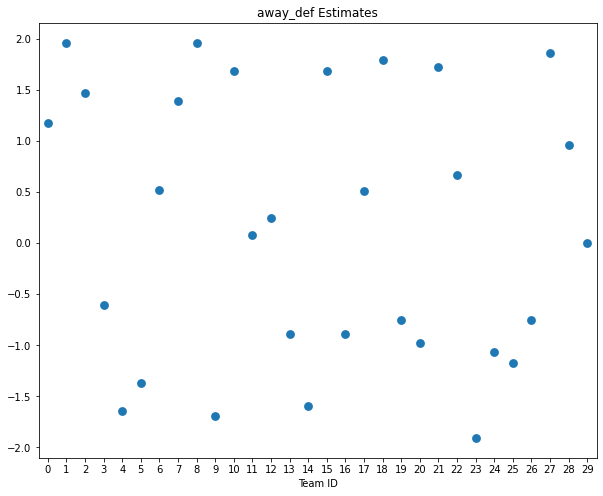

In [8]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
    
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

Predicting

In [ ]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'phi_home', 'phi_away', 'c_offset']
param_dict = {param: sim.stan_variable(param) for param in parameters}
# for key, val in param_dict.items():
#     print(key, val.shape)

# Extracting the samples that we need
def predict(row):
    # print(row)
    # print(type(row))
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    size_home = param_dict['phi_home']
    size_away = param_dict['phi_away']
    c_offset = param_dict['c_offset']
    # Creating the log_mu parameters
    mu1 = home_att + away_def + c_offset
    mu2 = home_def + away_att + c_offset
    
    print(size_home)
    print(size_away)
    
    # Simulating from a negative binomial distribution to obtain predictive distribution
    # y1 = np.array([nbinom.rvs(n=size_home[i], p=np.exp(log_mu1[i]) / (np.exp(log_mu1[i]) + size_home[i])) for i in range(samples)])
    # y2 = np.array([nbinom.rvs(n=size_away[i], p=np.exp(log_mu2[i]) / (np.exp(log_mu2[i]) + size_away[i])) for i in range(samples)])
    # y1 = np.array([nbinom.rvs(n=size_home[i], p=np.exp(log_mu1[i]) / (np.exp(log_mu1[i]) + size_home[i])) for i in range(samples)])
    # y2 = np.array([nbinom.rvs(n=size_away[i], p=np.exp(log_mu1[i]) / (np.exp(log_mu2[i]) + size_away[i])) for i in range(samples)])
    y1 = np.array([nbinom.rvs(n=size_home[i], p=size_home[i] / (mu1[i] + size_home[i])) for i in range(samples)])
    y2 = np.array([nbinom.rvs(n=size_away[i], p=size_away[i] / (mu2[i] + size_away[i])) for i in range(samples)])
    # predicted_scores = [np.bincount(y1, minlength=7), np.bincount(y2, minlength=7)]
    
    # A = np.zeros(7)
    # B = np.zeros(7)
    # for i in range(6):
    #     A[i] = predicted_scores[0][i] / np.sum(predicted_scores[0])
    #     B[i] = predicted_scores[1][i] / np.sum(predicted_scores[1])
    
    # A[6] = 1 - np.sum(A[:6])
    # B[6] = 1 - np.sum(B[:6])
    
    # name = ["0", "1", "2", "3", "4", "5", "6+"]
    # C = pd.DataFrame(index=name, columns=name)
    
    # for i in range(7):
    #     for j in range(7):
    #         C.iloc[i, j] = A[j] * B[i]
    print(y1)
    print(y2)
    # print(np.mean(y1 > y2), np.mean(y1 == y2), np.mean(y1 < y2))
    # print(np.mean(y1 > y2) + np.mean(y1 == y2) + np.mean(y1 < y2))
    # # Return predicted scores along with the home and away team for reference
    # predictions = {'HomeTeam': home_team, 'AwayTeam': away_team, 'score_probabilities': C}
    return pd.Series({
            'home_team_win_prob': np.mean(y1 > y2),
            'away_team_win_prob': np.mean(y1 < y2)
    })
    
seasons_games[pred_year][['home_team_win_prob', 'away_team_win_prob']] = seasons_games[pred_year].apply(predict, axis=1)

[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818]
[ 16 236  65 ... 141 100 174]
[146   2   9 ...   0  38   0]
[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818]
[12  0  0 ...  1  0  0]
[ 72   0 227 ... 680   0  61]
[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818]
[ 84   1   0 ...   0 630  55]
[115  24   0 ...  29   3  20]
[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818]
[  2   0 250 ...  45 233 464]
[  0 790   0 ...   0 130   1]
[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818]
[442 255   0 ...  25   0 134]
[0 0 0 ... 4 0 0]
[0.152992 0.152992 0.152992 ... 0.152992 0.152992 0.152992]
[0.129818 0.129818 0.129818 ... 0.129818 0.129818 0.129818

KeyboardInterrupt: 

In [14]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'c_offset', 'home_advantage']
param_dict = {param: sim.stan_variable(param) for param in parameters}
# for key, val in param_dict.items():
#     print(key, val.shape)

# Extracting the samples that we need
def predict(row):
    # print(row)
    # print(type(row))
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    c_offset = param_dict['c_offset']
    home_advantage = param_dict['home_advantage']
    
    theta_home_pred = np.exp(home_att + away_def + c_offset + home_advantage)
    theta_away_pred = np.exp(away_att + home_def + c_offset)

    home_score_pred = np.random.poisson(theta_home_pred)
    away_score_pred = np.random.poisson(theta_away_pred)
    
    for i in range(len(home_score_pred)):
        if home_score_pred[i] == away_score_pred[i]:
            point = 1 if np.random.rand() > 0.5 else -1
            if np.random.rand() > 0.5:
                home_score_pred[i] += point
            else:
                away_score_pred[i] += point
    
    home_points_difference = row['home_team_score'] - home_score_pred
    away_points_difference = row['away_team_score'] - away_score_pred
    
    print(home_score_pred)
    print(away_score_pred)
    # print(np.mean(y1 > y2), np.mean(y1 == y2), np.mean(y1 < y2))
    # print(np.mean(y1 > y2) + np.mean(y1 == y2) + np.mean(y1 < y2))

    return pd.Series({
            'home_team_win_prob': np.mean(home_score_pred > away_score_pred),
            'away_team_win_prob': np.mean(home_score_pred < away_score_pred),
            'mean_home_score': np.mean(home_score_pred),
            'mean_away_score': np.mean(away_score_pred),
            'std_home_score': np.std(home_score_pred),
            'std_away_score': np.std(away_score_pred),
            'mean_home_points_difference': np.mean(home_points_difference),
            'mean_away_points_difference': np.mean(away_points_difference),
            'std_home_points_difference': np.std(home_points_difference),
            'std_away_points_difference': np.std(away_points_difference),
            'is_win_team_predicted': np.mean(home_score_pred > away_score_pred) > 0.5 and row['home_team_score'] > row['away_team_score'] or
                                        np.mean(home_score_pred < away_score_pred) > 0.5 and row['home_team_score'] < row['away_team_score']
    })
    
seasons_games[pred_year][['home_team_win_prob', 
                          'away_team_win_prob', 
                          'mean_home_score',
                          'mean_away_score',
                          'std_home_score',
                          'std_away_score',
                          'mean_home_points_difference',
                          'mean_away_points_difference',
                          'std_home_points_difference',
                          'std_away_points_difference',
                          'is_win_team_predicted']] = seasons_games[pred_year].apply(predict, axis=1)

[ 91  86 104 ... 100 106 103]
[101 102 114 ... 124 110 127]
[116 112 157 ... 129 131 110]
[ 96  97 105 ... 106 129 102]
[ 80 109  95 ... 113 112  99]
[119  94 114 ... 109 116 105]
[115 129 102 ... 102 113 116]
[ 90 120 116 ... 104 136 128]
[109 114 105 ...  99 110 129]
[118 118 114 ... 108 107 117]
[114 113 113 ... 102 107 111]
[100 114 114 ... 101 103 128]
[ 92 105  95 ...  98 105 103]
[ 86 103 124 ... 112 102  80]
[121 119 105 ... 126 116 146]
[114 121 120 ... 130 118 124]
[114  90 132 ... 113 108  94]
[137  92 103 ... 111 113 120]
[ 99 100 112 ... 115  92  98]
[111 114 114 ... 121 102 127]
[120 118 123 ... 123 106 118]
[112 131  97 ... 112 119 113]
[110 124 127 ... 124 105 113]
[ 96 108 119 ...  99 110 112]
[114 122  96 ... 104 112 117]
[ 93 111  98 ... 100 108  94]
[117 101 135 ... 101 102 117]
[108 124 123 ... 104 130  97]
[104 117 114 ... 113 132  87]
[128 109 113 ... 124 124 109]
[117 104  92 ...  95  92 107]
[130 105 105 ... 108 101 116]
[110 107 121 ... 109 116 121]
[114  90 1

In [15]:
print(seasons_games[pred_year].head())

                  start_time           away_team  away_team_score  \
0  2022-10-18 23:30:00+00:00  PHILADELPHIA 76ERS              117   
1  2022-10-19 02:00:00+00:00  LOS ANGELES LAKERS              109   
2  2022-10-19 23:00:00+00:00       ORLANDO MAGIC              109   
3  2022-10-19 23:00:00+00:00  WASHINGTON WIZARDS              114   
4  2022-10-19 23:30:00+00:00       CHICAGO BULLS              116   

               home_team  home_team_score  difference  home_team_id  \
0         BOSTON CELTICS              126           9            21   
1  GOLDEN STATE WARRIORS              123          14            16   
2        DETROIT PISTONS              113           4             4   
3         INDIANA PACERS              107          -7            26   
4             MIAMI HEAT              108          -8            15   

   away_team_id  home_team_win_prob  away_team_win_prob  mean_home_score  \
0            20             0.46950             0.53050        106.86725   
1     

In [16]:
accurracy = np.mean(seasons_games[pred_year]['is_win_team_predicted'])
print(accurracy)

0.5257575757575758
